# Introduction
In this tutorial, we will take a look at **Hierarchical Clustering** and also get introduced to the awesome **GeoPandas** library for creating simple maps in Python.

## Hierarchical Clustering
The hierarchical clustering algorithm operates by defining a "dissimilarity" measure (most commonly taken as the Euclidean distance) between pairs of data points. Each data point initially begins as its own cluster and the two "most similar" clusters join to form a new cluster and this is repeated iteratively until all the data points belong to the same cluster. Once this process is complete, a suitable number of clusters can be determined by the resulting **Dendrogram**. The advantage of this algorithm is that we do not need to decide on the number of clusters beforehand, as is the case with the k-means algorithm.   

The algorithm can be summarized as follows:

<pre>
*start with each observation in its own cluster

n_clusters = n_observations

while n_clusters > 1:
      
      *compare all pairwise distances between clusters
      
      *find two clusters that are closest together and merge them
      
      n_clusters -= 1
</pre>

### Dendrograms
A dendrogram is a plot that can be used to assist with visualising hierarchical clustering as well as to determine the appropriate number of clusters. A dendrogram has the initial clusters on one axis (i.e. every datapoint) while the other axis shows dissimilarity (for example, the Euclidean distance between the clusters).   

![dendrogram](https://github.com/Samantha-movius/hello-world/blob/master/dendro.png?raw=true)   

#### An example
We start with the points that are the closest together as they join lowest down on the dissimilarity scale, these are known as the *leaves* of the dendrogram. In our example above, the following pairs of points are the closest and approximately equi-distant, thus forming the new clusters: B & C, E & F, H & I, and J & K. The next closest point is A, which is closest to the cluster containing B & C, so it joins that cluster and so on and this process continues until all points are within a single cluster, as seen above on the left. 

#### Choosing an appropriate number of clusters
In order to determine the ideal number of clusters that should be chosen using the dendrogram, we look for the largest vertical distance that would not be intersected if the perpendicular lines to the dissimilarity axis were extended. To clarify this, the figure below might help.   

![dendro_2](https://github.com/Samantha-movius/hello-world/blob/master/dendro2.png?raw=true)   

The lines perpendicular to the dissimilarity axis have been extended as dashed lines, and the maximum uninterrupted distance parallel to the dissimilarity axis, is indicated by the red arrow. We can determine the ideal number of clusters by looking at how many lines run parallel to the dissimilarity axis in this area (which is clearly 2 as there are two lines parallel to the dissimilarity axis within this area).

## Hierarchical clustering in Python
We will now perform hierarchical clustering on the [US census demographic data](https://www.kaggle.com/muonneutrino/us-census-demographic-data) and see how our results compare to the k-means clustering performed in the previous tutorial.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import ward, dendrogram
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('acs2015_county_data.csv', encoding='utf-8').dropna()

In [3]:
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [4]:
df.shape

(3218, 37)

### Scaling of features
Since we are dealing with a distance measure between points, we are going to need to scale our data before computing dissimilarities. Without scaling our data, the results of the clustering would most likely be depending on the feature(s) with the largest measurement scale.   

We will create a new 2D array called **X** containing the scaled features so that we can profile the clusters in their original units of measure later.

In [5]:
labels = ['CensusId', 'State', 'County']
features = [col for col in df.columns if col not in labels]

scaler = StandardScaler()
df[features] = df[features].astype('float64')
X = scaler.fit_transform(df[features])

C:\Users\jlesl\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


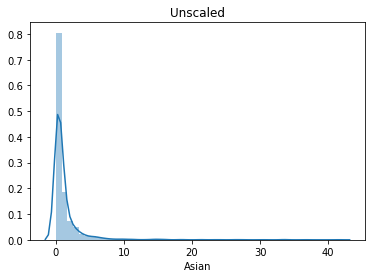

In [6]:
sns.distplot(df.iloc[:,10])
plt.title('Unscaled')
plt.show()

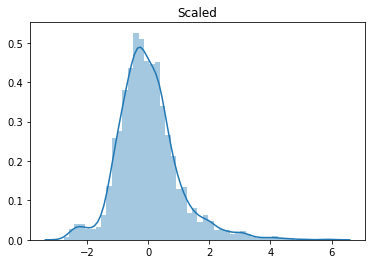

In [7]:
sns.distplot(X[:,10])
plt.title('Scaled')
plt.show()

## How we decide on which clusters to merge?
Hierarchical clustering requires us to choose two hyperparameters:
  1. distance metric
  2. linkage method
  
Each of these hyperparameters will determine the criteria on which we base our decision to merge two clusters.  

### Distance method
There are wide variety of distance metrics from which to choose. The most commonly used metric is the Euclidean distance, which is the straight line distance between two points. Other common metrics include the Chebyshev and Manhattan distances, see below:   
![metrics](https://github.com/James-Leslie/Learning-Library/blob/master/images/distance-metrics.png?raw=true)   

Here is a great explanation of these three metrics, taken from [this website](https://lyfat.wordpress.com/2012/05/22/euclidean-vs-chebyshev-vs-manhattan-distance/):   

> "In chess, the distance between squares on the chessboard for rooks is measured in Manhattan distance; kings and queens use Chebyshev distance, and bishops use the Manhattan distance (between squares of the same color) on the chessboard rotated 45 degrees, i.e., with its diagonals as coordinate axes. To reach from one square to another, only kings require the number of moves equal to the distance; rooks, queens and bishops require one or two moves (on an empty board, and assuming that the move is possible at all in the bishop’s case)."

There are still many more distance metrics from which you can choose. We will be using the `scipy` library for clustering, so you should take a look at [their docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) for a list of all available distance metrics.

### Linkage method
The linkage method determines _how_ we measure the chosen distance between two clusters.   

Take a moment to consider how you would measure the distance between two clusters with multiple points... Would you choose to measure the distance between the closest two points? The furthest? Take the average of all distances?   

In fact, all of these are valid options! The diagram below illustrates the three most common linkage methods:

![linkage](https://github.com/James-Leslie/Learning-Library/blob/master/images/linkage-methods.png?raw=true)   

  1. **Single linkage:** distance between two closest points   
  2. **Complete linkage:** distance between two furthest points   
  3. **Average linkage:** average of all pairwise distances between points
  
Again, there are still a few more linkage methods which you can check out in the [Scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).

In this tutorial, we will be using [Ward's minimum variance method](https://en.wikipedia.org/wiki/Ward%27s_method) for our linkage method with the Euclidean distance metric. You are encouraged to try out different distance metrics and linkage methods and see how your results differ.   

## Generate dendrogram
Now that we have chosen our hyperparameters, we can create our dendrogram by performing hierarchical clustering on our scaled features.

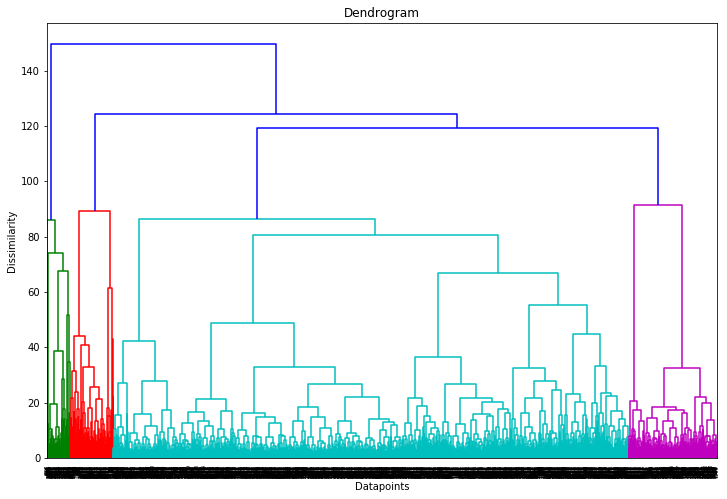

In [8]:
# plot dendrogram
plt.figure(figsize=(12,8))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward', metric='euclidean'))
plt.title('Dendrogram')
plt.xlabel('Datapoints')
plt.ylabel('Dissimilarity')

plt.show()

The dendrogram provides us with a record of which clusters were merged at each iteration, and the resulting increase in total dissimilarity. Initially, all observations began as their own clusters (0 on the y-axis) and were iteratively merged until all observations belonged to the same cluster (top of the y-axis).      

We choose our optimal number of clusters by looking for the point at which merging the closest two clusters results in the greatest increase in dissimilarity. The Scipy plotting method helps us out a little bit here by indicating the optimal number of clusters with colours. We can see that the greatest increase in dissimilarity occurs when we merge from 4 into 3 clusters, so we will therefore choose to use 4 clusters.

In [9]:
hc = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean').fit(X)
df['cluster'] = hc.labels_ + 1
df['cluster'] = df['cluster'].astype('int64')

## Cluster profiling
The next step is to explore the results of clustering. Can we identify any patterns or trends in the four clusters?   

Let's start by aggregating the clusters by their median feature values:

In [11]:
df.groupby('cluster').agg('median').T

cluster,1,2,3,4
CensusId,28093.0,30016.00,31116.00,26099.0
TotalPop,22217.0,28900.00,3001.00,896943.0
Men,10787.0,14475.50,1505.50,434784.0
Women,11224.0,14443.50,1477.50,463213.0
Hispanic,3.5,3.80,2.90,16.2
White,52.0,87.70,87.95,54.4
Black,33.1,1.60,0.20,11.0
Native,0.1,0.30,0.80,0.2
Asian,0.2,0.60,0.20,5.6
Pacific,0.0,0.00,0.00,0.0


### What's plotting?
Let's try and get creative with some plots and see if we can discover some insights.   

We will start with a few simple bar plots.

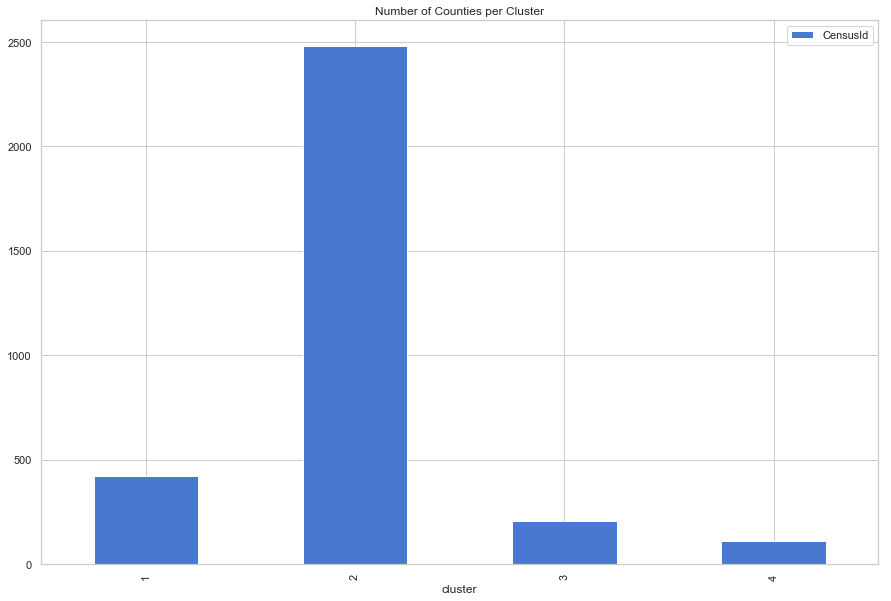

In [12]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

df[['CensusId', 'cluster']].groupby(
    'cluster').count().reset_index().plot(kind='bar', 
                                              x='cluster', 
                                              title='Number of Counties per Cluster')
plt.show()

**Analysis:** We can see that almost 2500 of the counties belong to cluster 2.

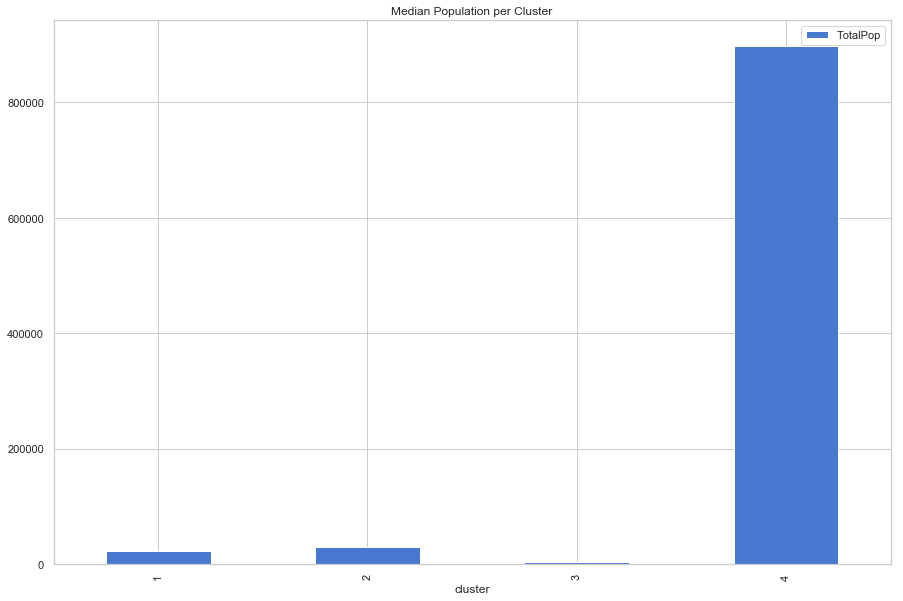

In [13]:
df[['TotalPop','cluster']].groupby(
    'cluster').agg('median').reset_index().plot(kind='bar', 
                                                x='cluster', 
                                                title='Median Population per Cluster')
plt.show()

**Analysis:** Cluster 4 contains the counties with the highest populations.

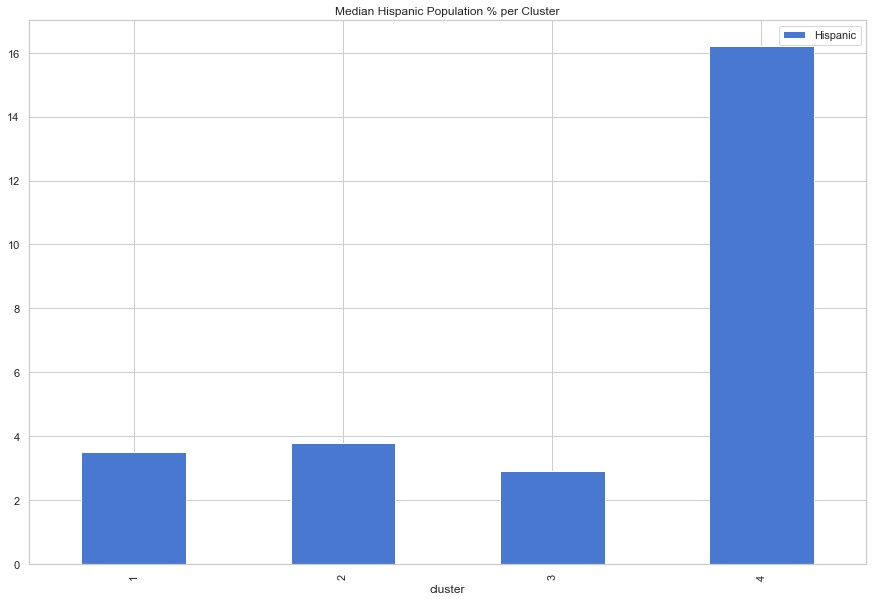

In [14]:
df[['Hispanic', 'cluster']].groupby(
    'cluster').agg('median').reset_index().plot(kind='bar', 
                                                x='cluster',
                                                title='Median Hispanic Population % per Cluster')
plt.show()

### Multi-dimensional plotting
Let's try to fit more features into a single plot. Remember, we have more visual channels than just the horizontal and vertical axes.   

Let's use both shape and colour to add two new dimensions to our plot. First, we will decide on a suitable palette with four colours:

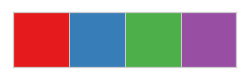

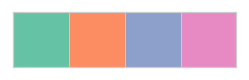

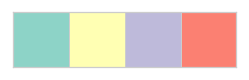

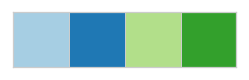

In [15]:
sns.palplot(sns.color_palette("Set1", n_colors=4))
sns.palplot(sns.color_palette("Set2", n_colors=4))
sns.palplot(sns.color_palette("Set3", n_colors=4))
sns.palplot(sns.color_palette("Paired", n_colors=4))

#### Custom colour palettes
Seaborn also provides support for using names from this [xkcd crowdsourced effort](https://blog.xkcd.com/2010/05/03/color-survey-results/) to name random RGB colours. You can find the list of colours [here](https://xkcd.com/color/rgb/).

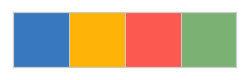

In [16]:
# choose four colours
colours = ["windows blue", "amber", "coral", "faded green"]
# plot them as a palette
sns.palplot(sns.xkcd_palette(colours))

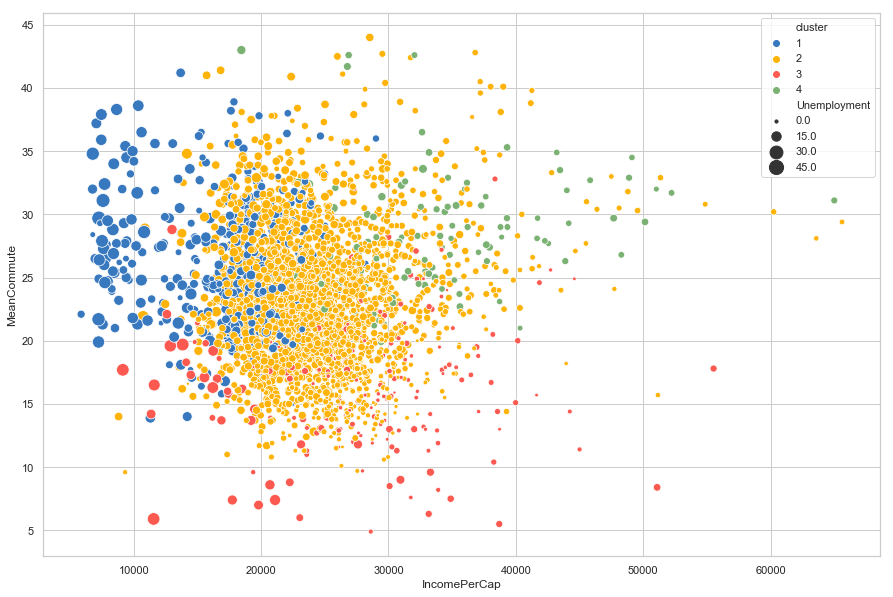

In [16]:
# create our colour palette
cmap = sns.xkcd_palette(colours)

ax = sns.scatterplot(x="IncomePerCap", y="MeanCommute",
                     hue="cluster", size="Unemployment",
                     palette=cmap, sizes=(10, 200),
                     data=df)
plt.show()

This is just a nudge in the right direction. You are encouraged to do some more interrogation of the clusters to gain further insights.

> make use of the [seaborn example gallery](https://seaborn.pydata.org/examples/index.html) for some inspiration

## Quick introduction to geospatial data analysis
We will finish off this tutorial with an introduction to a really cool Python library for working with geospatial data, called [GeoPandas](http://geopandas.org/).   

Before you continue, make sure you install this library using `conda install geopandas`.   

To load a GeoDataFrame, you do it in a very similar way to loading a regular Pandas DataFrame. We have provided a [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) called `us-counties.json` which can be read straight into GeoPandas a GeoDataFrame:

In [17]:
gdf = gpd.read_file('us-counties.json')

GeoDataFrames inherit all the same methods as regular DataFrames. The only difference is that a GeoDataFrame must have a column named `geometry` which contains the spatial features relating to each observation in the data.   

There are three basic classes of geometric objects:   
  - Points (x,y coordinate pairs)
  - Lines (multiple points which define segments)
  - Polygons (multiple connected lines which form an enclosed shape)

In [18]:
gdf.head()

,id,name,geometry
0,1001,Autauga,"POLYGON ((-86.41178600000001 32.706342, -86.41..."
1,1003,Baldwin,"POLYGON ((-87.76459 31.298768, -87.616713 31.2..."
2,1005,Barbour,"POLYGON ((-85.354736 32.147694, -85.053504 32...."
3,1007,Bibb,"POLYGON ((-87.063542 33.248559, -87.025203 33...."
4,1009,Blount,"POLYGON ((-86.488463 34.261793, -86.455601 34...."


Our GeoDataFrame consists of all the US counties and their respective polygons. Let's merge this GeoDataFrame with our original DataFrame:

In [19]:
gdf['id'] = gdf['id'].astype('int64')

In [20]:
df = pd.merge(left=df, right=gdf, how='inner', left_on='CensusId', right_on='id')
del df['id']
del df['name']
# convert to a GeoDataFrame
df = gpd.GeoDataFrame(df)

In [21]:
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,cluster,geometry
0,1001,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,...,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,2,"POLYGON ((-86.41178600000001 32.706342, -86.41..."
1,1003,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,...,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,2,"POLYGON ((-87.76459 31.298768, -87.616713 31.2..."
2,1005,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,...,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,1,"POLYGON ((-85.354736 32.147694, -85.053504 32...."
3,1007,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,...,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,2,"POLYGON ((-87.063542 33.248559, -87.025203 33...."
4,1009,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,...,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,2,"POLYGON ((-86.488463 34.261793, -86.455601 34...."


Now, we can plot the counties as a map:

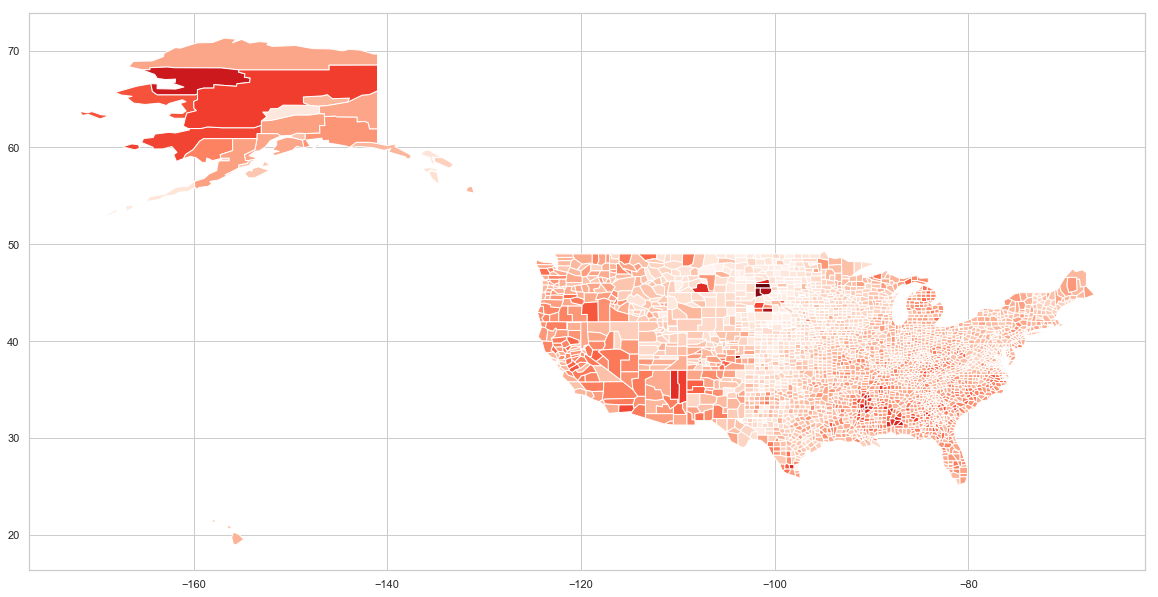

In [22]:
df.plot(column='Unemployment',
        cmap='Reds',
        figsize=(20,20))
plt.show()

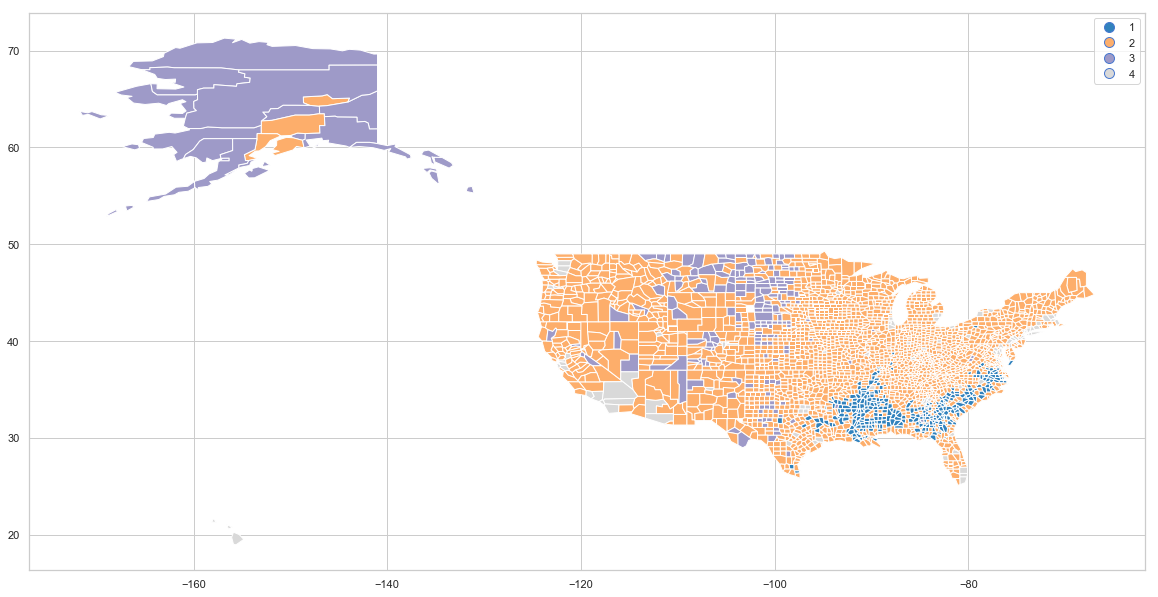

In [23]:
# geopands requires a cmap (rather than just a palette)
# cmap = ListedColormap(cmap.as_hex())

df.plot(column='cluster',
        cmap='tab20c',
        figsize=(20,20),
        categorical=True,
        legend=True)
plt.show()